In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\ayxan\AppData\Local\Temp\ipykernel_11972\3948070972.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [2]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# data preparing

In [3]:
data=np.random.randint(-10,10,(1000,2))
result=data[:,0]+data[:,1]

datatensor=torch.tensor(data).float()
resulttensor=torch.tensor(result).float()
resulttensor=resulttensor[:,None]

output={}
output['data']=datatensor
output['result']=resulttensor

train_data,devtest_data,train_label,devtest_label=train_test_split(datatensor,resulttensor,train_size=.8)
devset_data,test_data,devset_label,test_label=train_test_split(devtest_data,devtest_label,train_size=.5)

train_dataset=TensorDataset(train_data,train_label)
devset_dataset=TensorDataset(devset_data,devset_label)
test_dataset=TensorDataset(test_data,test_label)

output['train_loader']=DataLoader(train_dataset,batch_size=32,shuffle=True,drop_last=True)
output['devset_loader']=DataLoader(devset_dataset,batch_size=devset_dataset.tensors[0].shape[0])
output['test_loader']=DataLoader(test_dataset,batch_size=test_dataset.tensors[0].shape[0])


# neural network

In [16]:
def createModel():
    
    class Model(nn.Module):
        def __init__(self):
            super().__init__()
            self.input=nn.Linear(2,16)
            
            self.fc1=nn.Linear(16,16)
            self.fc2=nn.Linear(16,16)
            
            self.output=nn.Linear(16,1)
            
        def forward(self,x):
            x=F.relu(self.input(x))
            
            x=F.relu(self.fc1(x))
            x=F.relu(self.fc2(x))
            
            return self.output(x)
        
    ANN=Model()
    
    lossfun=nn.MSELoss()
    
    optimizer=torch.optim.Adam(ANN.parameters(),lr=.001)
    
    return ANN,lossfun,optimizer

In [54]:
arr=torch.tensor(np.random.randint(-10,10,(10,2))).float()
ANN=createModel()[0]
ANN(arr)

tensor([[0.5515],
        [0.4701],
        [0.5129],
        [1.0655],
        [0.9808],
        [0.6093],
        [0.6344],
        [0.7172],
        [0.7823],
        [0.5116]], grad_fn=<AddmmBackward0>)

# model training process

In [107]:
def trainModel(Numepoch=100):
    
    losses=torch.zeros(Numepoch)
    test_losses=torch.zeros(Numepoch)
    
    trainAcc=[]
    devsetAcc=[]
    
    ANN,lossfun,optimizer=createModel()
    
    ANN.to(device)
    
    for epoch in range(Numepoch):
        batchAcc=[]
        batchloss=[]
        ANN.train()

        for dat,lab in output['train_loader']:

            dat=dat.to(device)
            lab=lab.to(device)
            
            yHat=ANN(dat)
            loss=lossfun(yHat,lab)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batchloss.append(loss.item())
            
            yHat=yHat.cpu()
            lab=lab.cpu()
            
            match=(torch.abs(yHat-lab)<1).float()
            batchAcc.append(100*torch.mean(match))
            
        losses[epoch]=np.mean(batchloss)
        trainAcc.append(np.mean(batchAcc))
        
        
        ANN.eval()
        
        dat,lab=next(iter(output['devset_loader']))
        dat=dat.to(device)
        lab=lab.to(device)

        with torch.no_grad():
            yHat=ANN(dat)
            
        yHat=yHat.cpu()
        lab=lab.cpu()
            
        match=(torch.abs(yHat-lab)<1).float()
        devsetAcc.append(100*torch.mean(match))    
        
    return ANN,losses,trainAcc,devsetAcc 

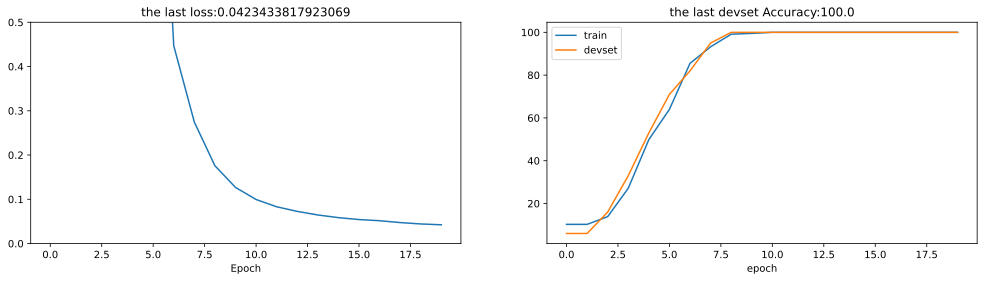

In [109]:
ANN,losses,trainAcc,devsetAcc=trainModel(20)

fig,ax=plt.subplots(1,2,figsize=(17,4))

ax[0].plot(losses)
ax[0].set_xlabel('Epoch')
ax[0].set_title(f"the last loss:{losses[-1]}")
ax[0].set_ylim([0,.5])

ax[1].plot(trainAcc,label='train')
ax[1].plot(devsetAcc,label='devset')
ax[1].set_xlabel('epoch')
ax[1].set_title(f'the last devset Accuracy:{devsetAcc[-1]}')
ax[1].legend()


In [110]:
dat,lab=next(iter(output['test_loader']))
dat=dat.to(device)

prediction=ANN(dat)
prediction=prediction.cpu()
corrTest=np.corrcoef(prediction.detach().T,lab.detach().T)[1,0]
corrTest

0.9997411707862961